In [2]:
def Compute_Theta_B(Lam, B1, B2):
    Theta=np.einsum("a,aib->aib",Lam,B1)
    Theta=np.einsum("aib,bjc->aijc",Theta,B2)
    return Theta
def antif_order(B, L, S,Lam):
  Mal = 0.
  for j in range(L):
    Maga = np.einsum("a,aib->aib",Lam[j],B[j+1])
    Maga = np.einsum("aib,ij->ajb",Maga,S)
    Laga = np.einsum("a,ajb->ajb",Lam[j],np.conj(B[j+1]))
    Mal += ((-1)^(j+1))*np.einsum("ajb,ajb->",Maga,Laga).real
  return Mal/L
def X_direction_state(chi,L,d):
   Gamma = []
   lamba = [np.array([1.])]
   for j in range(L):
    Gamma.append(np.zeros((chi[j],d,chi[j+1])).astype(complex))
    Gamma[j][0,0,0]=1./np.sqrt(2)+0j
    Gamma[j][0,1,0]=1./np.sqrt(2)+0j
    dui = np.zeros(chi[j+1])
    dui[0] = 1.
    lamba.append(dui)
   return Gamma,lamba

def magnetz_sum(B, L, S,Lam):
  Mal = 0.
  for j in range(L):
    Maga = np.einsum("a,aib->aib",Lam[j],B[j+1])
    Maga = np.einsum("aib,ij->ajb",Maga,S)
    Laga = np.einsum("a,ajb->ajb",Lam[j],np.conj(B[j+1]))
    Mal += np.einsum("ajb,ajb->",Maga,Laga).real
  return Mal/L

def Antiferromagnet(chi,L,d):
   Gamma = []
   lamba = [np.array([1.])]
   for j in range(L):
    if j%2==0:
     Gamma.append(np.zeros((chi[j],d,chi[j+1])).astype(complex))
     Gamma[j][0,0,0]=1./np.sqrt(2)+0j
     Gamma[j][0,1,0]=1./np.sqrt(2)+0j
     dui = np.zeros(chi[j+1])
     dui[0] = 1.
     lamba.append(dui)
    else:
     Gamma.append(np.zeros((chi[j],d,chi[j+1])).astype(complex))
     Gamma[j][0,0,0]=1./np.sqrt(2)+0j
     Gamma[j][0,1,0]=-1./np.sqrt(2)+0j
     dui = np.zeros(chi[j+1])
     dui[0] = 1.
     lamba.append(dui)
   return Gamma,lamba

def apply_two_site_unitary1(Lam, B1, B2,U,chis,j):
    Theta = Compute_Theta_B(Lam, B1, B2)

    Theta = np.einsum("ijkl,aijb->aklb",U,Theta)
    Theta = Theta.reshape(chis[j]*d,chis[j+2]*d)         

    Sigma,lam_1,Ve,e_n=truncate(j,Theta,chis,L,d=2)

    vi=np.divide(1.0, Lam, out=np.zeros_like(Lam), where=np.abs(Lam)>=1E-14)

    B1 = np.einsum("a,aib->aib",vi,Sigma) 
    B1 = np.einsum("aib,b->aib",B1,lam_1)  

    B2 = Ve 
    return Lam,lam_1, B1, B2,e_n


In [5]:
import numpy as np
from Library import Convert_to_A_and_B, ka, truncate, Create_random_MPS, Pauli, Model_coefficients, Create_Hamiltonian, Entropy,Truncation_error
from quspin.basis import spin_basis_general # Hilbert space spin basis
import matplotlib.pyplot as plt
from scipy.linalg import expm
import csv
dt = 0.1    # time step
T = 10*2    # total time
N = int(T/dt)     # Number of updates
time  = np.arange(0,T,dt)

L = 100       # system size
chi = 145             # Bond dimension
d = 2                                  # Dimension of physical index
h_x, h_y, h_z = 0.5, np.log(2), 0.5  # Field in the different directions
J_xx, J_yy, J_zz = 1., 0., 0.29  # Strength of spin interactions
chis = ka(L,chi)

Entropiq = np.zeros(N+1)
Model = [["z"],["x","z"]]     # The first part of the model gives us the spin interaction and the second one the fields
Interactions, Fields = Model_coefficients(J_xx,J_yy,J_zz,h_x,h_y,h_z)
S_z, S_x, S_y, S1 = Pauli()

Gamma,Lambda = Antiferromagnet(chis,L,d)
_, B = Convert_to_A_and_B(Gamma, Lambda,L)
print(antif_order(B, L, S_x,Lambda))

0.5


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


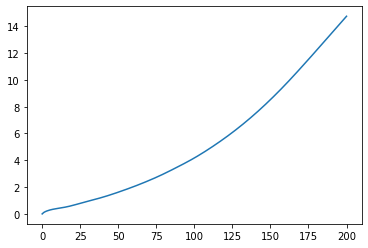

In [6]:
Magnet_Z = np.zeros(N+1)
E_D = np.zeros(N)
e_n= np.zeros(L)
H  = Create_Hamiltonian(Model,S1,Interactions,Fields,d)
U=expm(-1j*dt*H.reshape(d**2,-1)).reshape(d,d,d,d)
Magnet_Z[0] =  magnetz_sum(B, L, S_z,Lambda)
# Time evolution operator
for ty in range(N):
  print(ty)
  for j in range(1,L-1,2):
    Lambda[j], Lambda[j+1], B[j+1], B[j+2],e_n[j] = apply_two_site_unitary1(Lambda[j], B[j+1], B[j+2],U,chis,j)

  for j in range(0,L,2):
    Lambda[j], Lambda[j+1], B[j+1], B[j+2],e_n[j] = apply_two_site_unitary1(Lambda[j], B[j+1], B[j+2],U,chis,j)
  Entropiq[ty+1] = Entropy(Lambda[len(Lambda)//2])
  Magnet_Z[ty+1] =  magnetz_sum(B, L, S_z,Lambda)
  E_D[ty] = Truncation_error(e_n)

#Mz_iTEBD = np.zeros(N+1).astype(data_type)
#Mz_iTEBD[0] = Exp_value_two_site(lam[0],Gamma[0],lam[1],Gamma[1],S_z,S_z)
plt.plot(Entropiq)
File_name = 'Data_MPS/MFITEBD_dt='+ str(dt)+"_L="+str(L)+"chi_max="+str(chi) +"_T="+str(T)+"_Jihx=0.5"+".csv"

with open(File_name, 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Time"])
    writer.writerow(time)
       
    writer.writerow(["Entropy"])
    writer.writerow(Entropiq)

    writer.writerow(["M_z"])
    writer.writerow(Magnet_Z)

    writer.writerow(["Trunc. error"])
    writer.writerow(E_D)

    

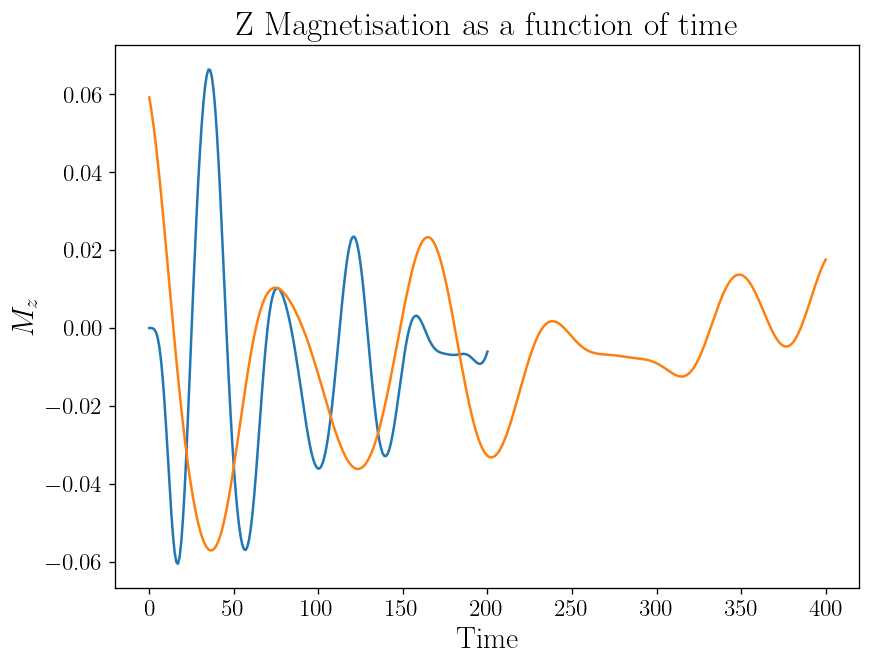

In [55]:
os.environ["PATH"] += ':/usr/local/texlive/2015/bin/x86_64-darwin'
figure(figsize=(8, 6), dpi=120)
plt.tick_params(labelsize=14)

plt.plot(Magnet_Z,label=r"dt=0.1")
plt.plot(Magnet_Z1,label=r"dt=0.1")
#plt.plot(Magnet_Z2,label=r"dt=0.3")

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.ylabel(r"$M_z$",fontsize=18)
plt.xlabel("Time",fontsize=18)
plt.title("Z Magnetisation as a function of time",fontsize=20)
#plt.legend(fontsize=12)
plt.savefig("MFITEBDZMAG.pdf",format="pdf")
plt.show()


In [7]:
File_name = 'Data_MPS/MFITEBD_dt='+ str(dt)+"_L="+str(L)+"chi_max="+str(chi) +"_T="+str(T)+"_Jihx=0.5"+".csv"

with open(File_name, 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Time"])
    writer.writerow(time)
       
    writer.writerow(["Entropy"])
    writer.writerow(Entropiq)

    writer.writerow(["M_z"])
    writer.writerow(Magnet_Z)

    writer.writerow(["Trunc. error"])
    writer.writerow(E_D)

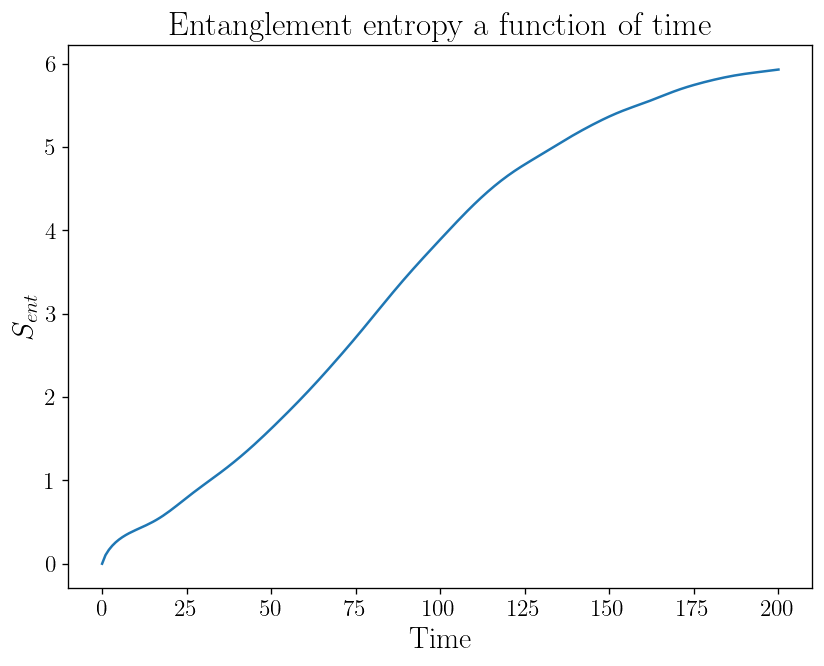

In [50]:
os.environ["PATH"] += ':/usr/local/texlive/2015/bin/x86_64-darwin'
figure(figsize=(8, 6), dpi=120)
plt.tick_params(labelsize=14)

plt.plot(Entropiq,r"dt=0.1")
plt.plot(Entropiq1,r"dt=0.1")
plt.plot(Entropiq2,label=r"dt=0.3")

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.ylabel(r"$S_{ent}$",fontsize=18)
plt.xlabel("Time",fontsize=18)
plt.title("Entanglement entropy a function of time",fontsize=20)
#plt.legend(fontsize=12)
plt.savefig("MFIent.pdf",format="pdf")
plt.show()

In [35]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import numpy as np
import csv
import os
from Library import Entropy
import pandas as pd
from matplotlib.pyplot import figure


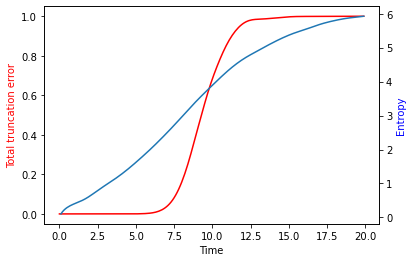

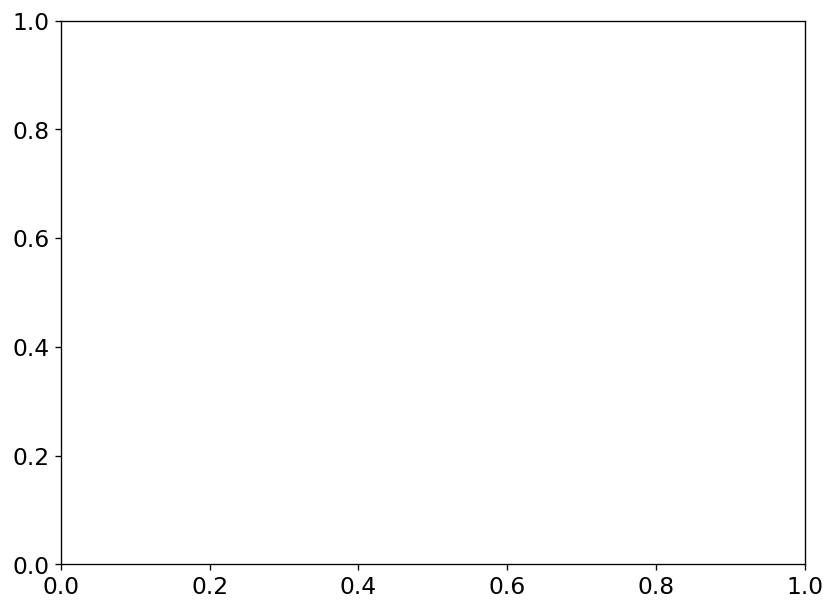

In [38]:
fig, ax1 = plt.subplots()
figure(figsize=(8, 6), dpi=120)
plt.tick_params(labelsize=14)
ax2 = ax1.twinx()
ax1.plot(time, E_D, 'r-')
ax2.plot(time, Entropiq[:200])

ax1.set_xlabel('Time')
ax1.set_ylabel('Total truncation error', color='r')
ax2.set_ylabel('Entropy', color='b')

plt.show()